# Overview

This example notebook showcases the main features of Meteora. To that end, we will download and process meteorological observations from [the Automated Surface/Weather Observing Systems (ASOS/AWOS) program](https://www.ncei.noaa.gov/products/land-based-station/automated-surface-weather-observing-systems), which comprises more than 900 automated weather stations in the United States.

More precisely, we will use the `METARASOSIEMClient` to stream [METAR](https://madis.ncep.noaa.gov/madis_OMO.shtml) from the [Iowa Environmental Mesonet](https://mesonet.agron.iastate.edu/request/asos/1min.phtml)

In [ ]:
import contextily as cx

from meteora.clients import METARASOSIEMClient

## Meteora clients

Meteora is essentially a collection of "client" classes that allow [processing data from different providers](https://meteora.readthedocs.io/en/latest/supported-providers.html) in a standardized interface. The following sections will go through the main aspects of a Meteora client.

### Selecting the client's region of interest

All clients are instantiated with at least the `region` argument, which defines the spatial extent of the required data. The `region` argument can be either:

- A string with a place name (Nominatim query) to geocode.
- A sequence with the west, south, east and north bounds.
- A geometric object, e.g., shapely geometry, or a sequence of geometric objects. In such a case, the region will be passed as the `data` argument of the GeoSeries constructor.
- A geopandas geo-series or geo-data frame.
- A filename or URL, a file-like object opened in binary (`'rb'`) mode, or a `Path` object that will be passed to `geopandas.read_file`.

In this case, we will use the country of Switzerland as defined by a query to the [Nominatim API](https://nominatim.org) (via [osmnx](https://github.com/gboeing/osmnx)):

In [ ]:
region = "Switzerland"

We can now instantiate our client:

In [ ]:
client = METARASOSIEMClient(region)

### Stations locations and metadata

The list of stations maintained by the provider within the selected region can be accessed using the `stations_gdf` property:

In [ ]:
client.stations_gdf.head()

,elevation,sname,time_domain,archive_begin,archive_end,state,country,climate_site,wfo,tzname,...,ncei91,ugc_county,ugc_zone,county,sid,network,online,synop,attributes,geometry
station_id,,,,,,,,,,,,,,,,,,,,,
LSGC,1027.0,Les Eplatures,(2001-Now),2001-07-21,NaT,None,CH,None,None,Europe/Zurich,...,None,None,None,None,LSGC,CH__ASOS,True,99999.0,"{ ""METAR_RESET_MINUTE"": ""50"", ""GHCNH_ID"": ""SZI...",POINT (6.7928 47.0838)
LSGG,416.0,Geneva,(1935-Now),1935-01-01,NaT,None,CH,None,None,Europe/Zurich,...,None,None,None,None,LSGG,CH__ASOS,True,99999.0,"{ ""METAR_RESET_MINUTE"": ""50"", ""GHCNH_ID"": ""SZI...",POINT (6.1278 46.2475)
LSGS,481.0,Sion,(1954-Now),1954-12-31,NaT,None,CH,None,None,Europe/Zurich,...,None,None,None,None,LSGS,CH__ASOS,True,99999.0,"{ ""METAR_RESET_MINUTE"": ""50"", ""GHCNH_ID"": ""SZI...",POINT (7.3303 46.2186)
LSMA,444.0,Alpnach,(1977-Now),1977-12-12,NaT,None,CH,None,None,Europe/Zurich,...,None,None,None,None,LSMA,CH__ASOS,True,99999.0,"{ ""METAR_RESET_MINUTE"": ""50"", ""GHCNH_ID"": ""SZI...",POINT (8.2858 46.9431)
LSMD,448.0,Dubendorf,(2004-Now),2004-09-03,NaT,None,CH,None,None,Europe/Zurich,...,None,None,None,None,LSMD,CH__ASOS,True,99999.0,"{ ""METAR_RESET_MINUTE"": ""50"", ""GHCNH_ID"": ""SZI...",POINT (8.65 47.4)


which is essentially a geopandas data frame that includes station metadata including the location, so we can, e.g., plot it in a map:

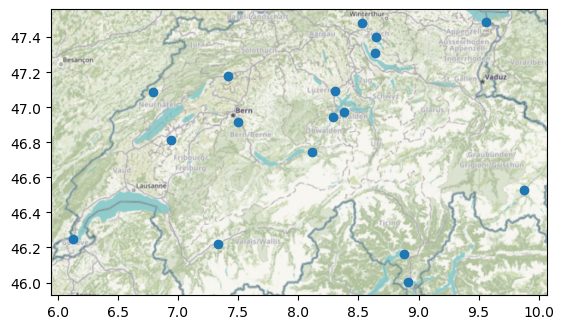

In [ ]:
ax = client.stations_gdf.plot()
cx.add_basemap(ax, crs=client.stations_gdf.crs, attribution=False)

*(C) OpenStreetMap contributors, Tiles style by Humanitarian OpenStreetMap Team hosted by OpenStreetMap France*

### Variables

The list of variables and their metadata is shown in the `variables_df` property:

In [ ]:
client.variables_df

,code,description
0,tmpf,Air Temperature
1,dwpf,Dew Point Temperature
2,relh,Relative Humidity
3,sknt,Wind Speed
4,drct,Wind Direction
5,mslp,Sea Level Pressure in millibar
6,p01i,1 minute precip


## Getting a time series of measurements

Given a list of variables and time range, we can use the `get_ts_df` method to get a time series of station measurements:

In [ ]:
variables = ["tmpf", "dwpf", "relh"]
start = "2021-08-13"
end = "2021-08-16"

ts_df = client.get_ts_df(variables, start=start, end=end)
ts_df

tmpf  dwpf   relh
station_id time                                  
LSGC       2021-08-13 00:20:00  60.8  53.6  77.14
           2021-08-13 00:50:00  60.8  53.6  77.14
           2021-08-13 01:20:00  60.8  53.6  77.14
           2021-08-13 01:50:00  59.0  53.6  82.25
           2021-08-13 02:20:00  59.0  53.6  82.25
...                              ...   ...    ...
LSZS       2021-08-15 21:50:00  51.8  48.2  87.47
           2021-08-15 22:20:00  51.8  48.2  87.47
           2021-08-15 22:50:00  51.8  48.2  87.47
           2021-08-15 23:20:00  50.0  46.4  87.37
           2021-08-15 23:50:00  50.0  46.4  87.37

[2304 rows x 3 columns]

### Selecting variables

When accessing to time series data (e.g., the `get_ts_df` method of each client), the `variables` argument is used to select the variables to retrieve. The `variables` argument can be either:

- a string or integer with variable name or code according to the provider's nomenclature, or
- a string referring to essential climate variable (ECV) following the Meteora nomenclature, i.e., a string among:

```python
ECVS = [
    "precipitation",  # Precipitation
    "pressure",  # Pressure (surface)
    "surface_radiation_longwave",  # Surface radiation budget (longwave)
    "surface_radiation_shortwave",  # Surface radiation budget (shortwave)
    "surface_wind_speed",  # Surface wind speed
    "surface_wind_direction",  # Surface wind direction
    "temperature",  # Air temperature (usually at 2m above ground)
    "water_vapour",  # Water vapour/relative humidity
]
```

See the guidelines by the [World Meteorological Organization](https://public.wmo.int/en/programmes/global-climate-observing-system/essential-climate-variables) on ECVs for more information.

In the returned time series data frames, **the variable labels will be the same as they have been passed to the `get_ts_df` method**. Therefore, if we were to assemble data frames for multiple clients (each with its own nomenclature), it may be better to use the common Meteora nomenclature, e.g., pass the variables as in:

In [ ]:
variables = ["temperature", "precipitation", "surface_wind_speed"]

ts_df = client.get_ts_df(variables, start=start, end=end)
ts_df

temperature  precipitation  surface_wind_speed
station_id time                                                               
LSGC       2021-08-13 00:20:00         60.8            0.0                 1.0
           2021-08-13 00:50:00         60.8            0.0                 2.0
           2021-08-13 01:20:00         60.8            0.0                 2.0
           2021-08-13 01:50:00         59.0            0.0                 0.0
           2021-08-13 02:20:00         59.0            0.0                 0.0
...                                     ...            ...                 ...
LSZS       2021-08-15 21:50:00         51.8            0.0                 4.0
           2021-08-15 22:20:00         51.8            0.0                 2.0
           2021-08-15 22:50:00         51.8            0.0                 4.0
           2021-08-15 23:20:00         50.0            0.0                 2.0
           2021-08-15 23:50:00         50.0            0.0                 1.0

[2304 rows x 3 columns]

Then, if we queried the time series data for another provider with different nomenclature, we would have the same variable names/column labels.

### Selecting date range

While some providers only allow access to the most recent data, e.g., latest 24 hours, others allow querying data for a specific date range. In the latter case, the `start` and `end` arguments can be used to select the date range, which can be any object that can be converted to a [pandas `Timestamp` object](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.Timestamp.html), i.e., a string, integer, float or a datetime object from the datetime module or numpy.

## Example plot

As a final example, we can plot the stations by mean temperature over the requested period:

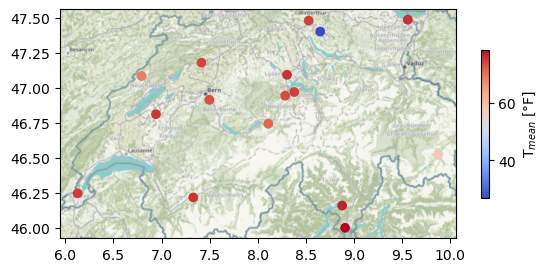

In [ ]:
t_mean_label = "T$_{mean}$ [°F]"

ax = client.stations_gdf.assign(
    **{t_mean_label: ts_df.groupby("station_id")["temperature"].mean()}
).plot(
    t_mean_label,
    cmap="coolwarm",
    legend=True,
    legend_kwds={"label": t_mean_label, "shrink": 0.4},
)
cx.add_basemap(ax, crs=client.stations_gdf.crs, attribution=False)

*(C) OpenStreetMap contributors, Tiles style by Humanitarian OpenStreetMap Team hosted by OpenStreetMap France*